In [1]:
#connecting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Archive:  drive/My Drive/Metaverse/train.zip
   creating: train/adidas/
  inflating: train/adidas/100.jpg    
  inflating: train/adidas/101.jpg    
  inflating: train/adidas/102.jpg    
  inflating: train/adidas/103.jpg    
  inflating: train/adidas/104.jpg    
  inflating: train/adidas/105.jpg    
  inflating: train/adidas/106.jpg    
  inflating: train/adidas/107.jpg    
  inflating: train/adidas/108.jpg    
  inflating: train/adidas/109.jpg    
  inflating: train/adidas/110.jpg    
  inflating: train/adidas/111.jpg    
  inflating: train/adidas/112.jpg    
  inflating: train/adidas/113.jpg    
  inflating: train/adidas/114.jpg    
  inflating: train/adidas/115.jpg    
  inflating: train/adidas/116.jpg    
  inflating: train/adidas/117.jpg    
  inflating: train/adidas/118.jpg    
  inflating: train/adidas/119.jpg    
  inflating: train/adidas/120.jpg    
  inflating: train/adidas/121.jpg    
  inflating: train/adidas/122.jpg    
  inflating: train/adidas/123.jpg    
  inflating: tra

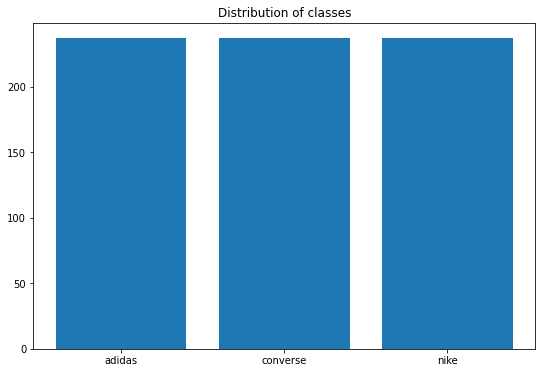


Dataset distribution in test
Number of adidas images : 38
Number of converse images : 38
Number of nike images : 38
Total images in test dataset: 114


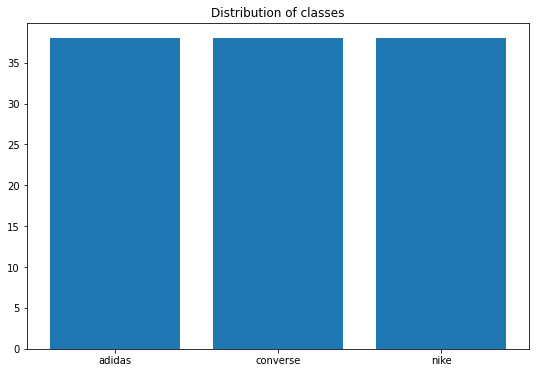

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

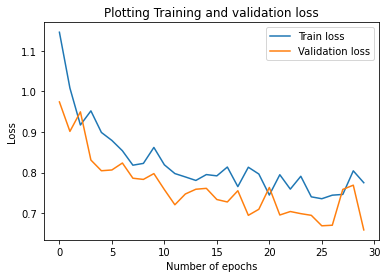


Plotting Training and validation loss


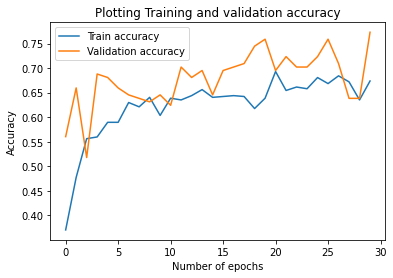


Testing starts!!!!!

Testing Accuracy of the model is: 81.57894736842105


In [2]:
#import the required libraries
import os
from os import listdir
import matplotlib.pyplot as plt
import time
import cv2
import matplotlib.image as mpimg
import numpy as np

#keras APIs
from tensorflow import reshape
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array, smart_resize



#DEFINING ALL METHODS

#to return the number of classes in the given dataset
def return_classes(dataset):
    classes = []
    for category in sorted(os.listdir(dataset)):
        classes.append(category)
    return classes

#class distribution of train and test dataset
def plot_class(dataset, classes):
    print('\nDataset distribution in {}'.format(dataset))
    nimgs = {}
    for c in classes:
        nimages = len(os.listdir(dataset + '/' + c +'/'))
        print('Number of {} images : {}'.format(c, nimages))
        nimgs[c] = nimages
    print('Total images in {} dataset: {}'.format(dataset, sum(nimgs.values())))
    plt.figure(figsize=(9, 6))
    plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
    plt.xticks(range(len(nimgs)), list(nimgs.keys()))
    plt.title('Distribution of classes')
    plt.show()


#using VGG16
def create_vgg():
    # load the VGG16 model with the pretrained weights and remove the last output layer
    vgg = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

    # Freeze the existing layers since we dont have to train them
    for layer in vgg.layers:
        layer.trainable = False

    z = vgg.output

    #Flatten the last layer
    z = GlobalAveragePooling2D()(z)

    #add a dropout parameter to avoid overfitting
    z = Dropout(0.5)(z)

    #number of classes
    out_neurons = len(return_classes('train'))

    #making the last output prediction layer using softmax as the activation function
    pred = Dense(out_neurons, activation='softmax')(z)

    # append the pretrained model with the new output layer
    model = Model(inputs = vgg.input, outputs = pred)

    # view the structure of the model
    model.summary()
    return model


#creating train and validation dataset
def create_train_valid_data():
    train_path = 'train'
  
    #using augmentation to create images and preprocessing done on images
    aug = ImageDataGenerator(rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            rescale = 1./255,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            fill_mode='nearest',
                            validation_split=0.2)


    #creating train dataset
    train_data_set = aug.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            shuffle = True,
                                            subset = "training",
                                            seed = 42,
                                            class_mode = 'categorical')

    #creating validation dataset
    valid_data_set = aug.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            shuffle = True,
                                            subset = "validation",
                                            seed = 42,
                                            class_mode = 'categorical')
    return train_data_set, valid_data_set 



#compile and run the generated model
def run_model(model, train_data_set, test_data_set):
    start = time.time()
    
    # cost and optimization method to use
    model.compile(
      loss = 'categorical_crossentropy',
      optimizer = Adam(learning_rate = 0.01),
      metrics = ['accuracy']
    )
    
    print("\nTraining starts!!!!!")
    run_vgg = model.fit(train_data_set,
                        validation_data = test_data_set,
                        epochs = 30,
                        steps_per_epoch = len(train_data_set),
                        validation_steps = len(test_data_set), 
                        )
    end = time.time()

    train_acc = run_vgg.history['accuracy']
    val_acc = run_vgg.history['val_accuracy']

    print("\nTraining accuracy: {}%, Validation accuracy: {}% and time taken: {} seconds".format(round(train_acc[-1]*100, 2), round(val_acc[-1]*100, 2), int(end - start)))
    return run_vgg


#plotting training and validation loss and accuracy
def plot_loss_acc(run_vgg):
    # Plotting loss
    print('\nPlotting Training and validation loss')
    plt.plot(run_vgg.history['loss'], label='Train loss')
    plt.plot(run_vgg.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.title('Plotting Training and validation loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Plotting accuracies
    print('\nPlotting Training and validation loss')
    plt.plot(run_vgg.history['accuracy'], label='Train accuracy')
    plt.plot(run_vgg.history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.title('Plotting Training and validation accuracy')
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.show()


#reading the images in test dataset to make predictions
def testing(model): 
    print("\nTesting starts!!!!!")
    
    predictions = []
    actual = []
    test_path = 'test'

    #a dictionary to hold the truth label for each class
    classes = return_classes('test')
    class_dict = {}
    i = 0
    for c in classes:
        class_dict[i] = c
        i +=1
    #class_dict  {0 : 'adidas', 1 : 'converse', 2 : 'nike'}

    #traversing through each class
    for k,v in class_dict.items():
        #path of each subfolder
        directory = test_path + "/" + v + "/"
      
        #for each image in the subfolders
        for img in os.listdir(directory):
            #reading each image
            img = mpimg.imread(os.path.join(directory,img))
            img = img_to_array(img)
            img = smart_resize(img, (224, 224))
            img = reshape(img, (-1, 224, 224, 3))

            #making predictions using the saved model
            prediction = model.predict(img/255)

            #saving the actual and prediction value
            actual.append(k)
            predictions.append(np.argmax(prediction))

    return actual, predictions


#method to calculate testing accuracy
def accuracy(actual, predictions):
    num_correct = 0
    for i in range(len(actual)):
        if predictions[i] == actual[i]:
            num_correct += 1     
    return (num_correct/ len(actual)) * 100.0 


#starting point of execution
if __name__ == '__main__':

    !unzip drive/My\ Drive/Metaverse/train.zip 
    !unzip drive/My\ Drive/Metaverse/test.zip 
    
    #class names in the given dataset
    classes = return_classes('train')
    print('\nClass names in the dataset: {}'.format(classes))

    #plotting class distribution in train and test class
    plot_class('train', classes)
    plot_class('test', classes)

    #creating image model using vgg16 pretrained model
    model = create_vgg()
    
    #creating train and validation data
    train_data_set, valid_data_set = create_train_valid_data()

    #training the model
    run_vgg = run_model(model, train_data_set, valid_data_set)
    model.save("Model.h5")
    plot_loss_acc(run_vgg)

    #testing and calculating predictions
    actual, predictions = testing(model)
    test_acc = accuracy(actual, predictions)
    print("\nTesting Accuracy of the model is:", test_acc)


    